# Introduction

This notebook demonstrates some basic data handling using the Pandas package and the application of linear methods to identify relationships in materials data. We will be creating a rudimentary prediction model for the bulk modulus of an element from various basic elemental properties. For the purposes of this exercise, we will assume that a linear relationship does indeed exist.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import matplotlib as mpl
import matplotlib.pyplot as plt

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
mpl.rcParams.update(params)

%matplotlib inline

## Load in the elemental dataset using pandas' read_csv method. This data was obtained from the Materials Project for the ground state structure of each element only.
The columns are:
- K: Bulk modulus in GPa
- MP: Melting point in K
- BP: Boiling point in K
- Z: Atomic number
- X: Pauling electronegativity
- r: Atomic radius in angstroms

In [2]:
data = pd.read_csv("element_data.csv", index_col=0)
print(data)

             K       MP      BP   Z     X     r
Element                                        
Ac        29.0  1323.00  3573.0  89  1.10  1.95
Ag        88.0  1234.93  2435.0  47  1.93  1.60
Al        83.0   933.47  2792.0  13  1.61  1.25
As        40.0  1090.00   887.0  33  2.18  1.15
Au       137.0  1337.33  3129.0  79  2.54  1.35
...        ...      ...     ...  ..   ...   ...
W        304.0  3695.00  5828.0  74  2.36  1.35
Y         41.0  1799.00  3609.0  39  1.22  1.80
Yb        15.0  1097.00  1469.0  70  1.10  1.75
Zn        67.0   692.68  1180.0  30  1.65  1.35
Zr        94.0  2128.00  4682.0  40  1.33  1.55

[83 rows x 6 columns]


Since a strict linear relationship may not exist between K and the other variables, we will create a few additional features based on simple transformations of the inputs.

In [3]:
# data["X^2"] = data["X"] ** 2
# data["sqrt(X)"] = data["X"] ** 0.5
# data["r^2"] = data["r"] ** 2
# data["sqrt(r)"] = data["r"] ** 0.5
print(data)

             K       MP      BP   Z     X     r
Element                                        
Ac        29.0  1323.00  3573.0  89  1.10  1.95
Ag        88.0  1234.93  2435.0  47  1.93  1.60
Al        83.0   933.47  2792.0  13  1.61  1.25
As        40.0  1090.00   887.0  33  2.18  1.15
Au       137.0  1337.33  3129.0  79  2.54  1.35
...        ...      ...     ...  ..   ...   ...
W        304.0  3695.00  5828.0  74  2.36  1.35
Y         41.0  1799.00  3609.0  39  1.22  1.80
Yb        15.0  1097.00  1469.0  70  1.10  1.75
Zn        67.0   692.68  1180.0  30  1.65  1.35
Zr        94.0  2128.00  4682.0  40  1.33  1.55

[83 rows x 6 columns]


For ease of interpretation, let's define our X and y.

In [4]:
features = [c for c in data.columns if c != "K"]
x = data[features]
y = data["K"]

We will now perform a standard multiple linear regression using scikit-learn.

K = -133.6 + 4.71e-02 MP + 2.87e-02 BP + -1.70e-01 Z + 4.75e+01 X + 6.33e+00 r


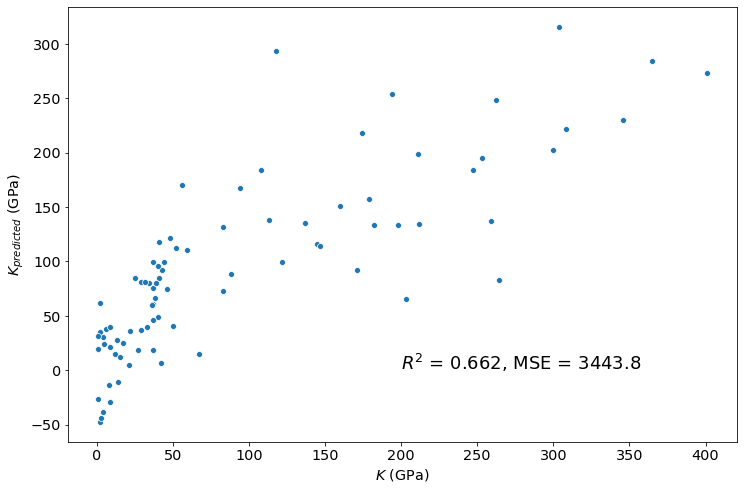

In [5]:
reg = linear_model.LinearRegression()
reg.fit(x, y)
r2 = reg.score(x, y)
equation = ["%.2e %s" % (v, f) for v, f in zip(reg.coef_, features)]
print("K = %.1f + %s" % (reg.intercept_, " + ".join(equation)))
f, ax = plt.subplots(figsize=(12, 8))
yhat = reg.predict(data[features])
sns.scatterplot(y, yhat)
l = plt.ylabel("$K_{predicted}$ (GPa)")
l = plt.xlabel("$K$ (GPa)")
l = plt.annotate("$R^2$ = %.3f, MSE = %.1f" % (r2, mean_squared_error(y, yhat)), (200, 0), fontsize=18)

# Correlations between features

Here, we will look at correlations between features. First, we do a pair plot between features.

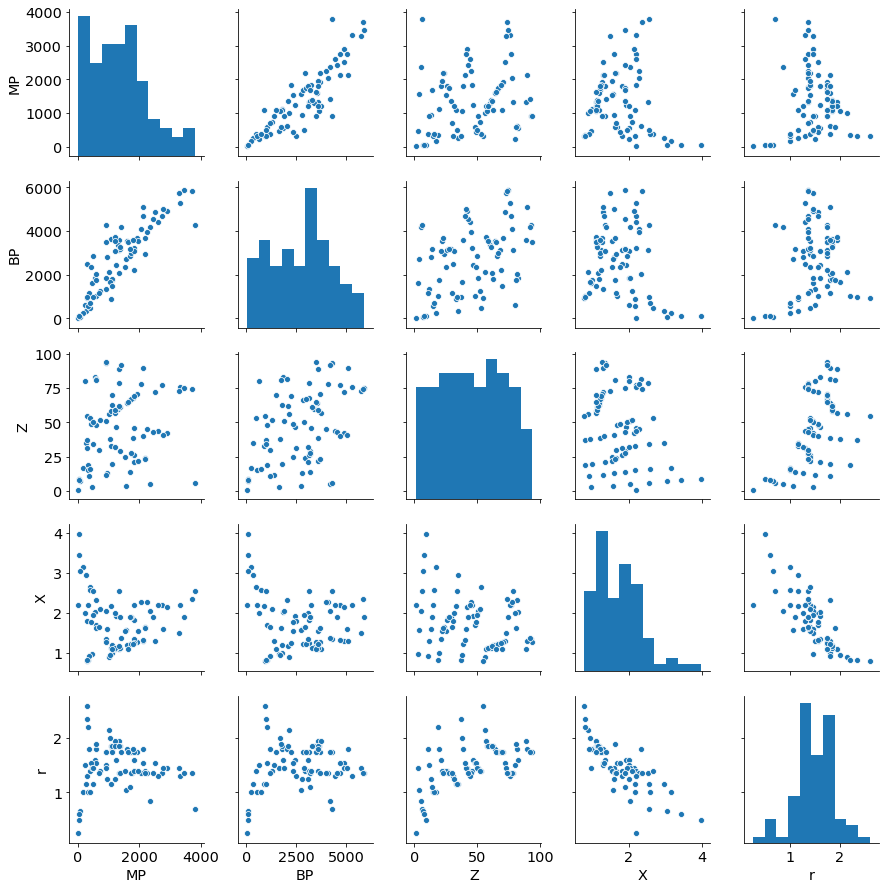

In [6]:
grid = sns.pairplot(data[features])

From the plot, it is clear that MP and BP are correlated with each other. And X is inversely related to r in some way. Obviously, X and $X^2$ are correlated. Another way to plot this is using a correlation plot.

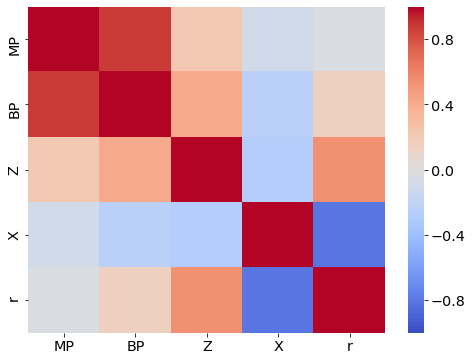

In [7]:
f, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(x.corr(), cmap="coolwarm", vmin=-1, vmax=1, ax=ax)

# Subset selection

Sometimes, the input variables may not be directly related to the interested target. Hence, a feature selection step is necessary. There are many different methods for selecting features. Here we will go over a simple implementation in scikit-learn,

In [8]:
from sklearn.feature_selection import SelectKBest, f_regression

def identify_columns(x_new, nrows=10):
    columns = x.columns
    xvalues = x.values
    dist = np.linalg.norm(xvalues[:nrows, :, None] - x_new[:nrows, None, :], axis=0)
    return columns[np.argmin(dist, axis=0)].values
    
sel = SelectKBest(f_regression, k=3)
x_new = sel.fit_transform(x, y)
print(f"Selected features {identify_columns(x_new)}")

Selected features ['MP' 'BP' 'r']


In [9]:
s = ', '.join(['%s: %.3f' % (i, j) for i, j in zip(x.columns, sel.pvalues_)])
print("The p values for the variables are " + s)

The p values for the variables are MP: 0.000, BP: 0.000, Z: 0.138, X: 0.176, r: 0.091


Apparently, the most significant variables are MP and BP (p values < 0.05), followed by r, Z and X.

# Shrinkage

Here, we will use shrinkage methods to shrink the feature coefficients.

In [10]:
scaler = StandardScaler()
scaler.fit(x)
means_ = scaler.mean_
stds_ = scaler.scale_
z = scaler.transform(x)

In [11]:
from sklearn.model_selection import cross_validate, KFold

/Users/chenchi/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


K = -73.5 + 4.56e-02 MP + 2.52e-02 BP + 9.81e-03 Z + 3.34e+01 X + -1.52e+01 r


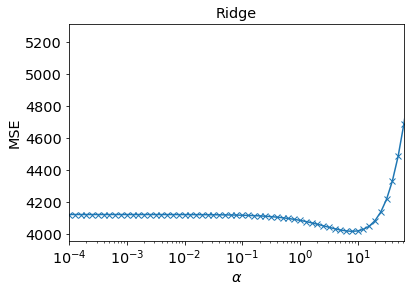

In [12]:
results = []
coeffs = []
alphas = np.logspace(-5, 2, 71)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

for alpha in alphas:
    ridge = linear_model.Ridge(alpha=alpha, max_iter=10000)
    ridge.fit(z, y)
    coeffs.append(ridge.coef_)
    scores = cross_validate(ridge, z, y, cv=kfold, scoring="neg_mean_squared_error")
    # print(scores)
    results.append((alpha, -np.mean(scores["test_score"])))

results = pd.DataFrame(results, columns=["alpha", "score"])
plt.plot(results["alpha"], results["score"], '-x')
plt.xlim([1e-4, 10**1.8])
plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel('MSE')
plt.title('Ridge')

best_alpha = results['alpha'][np.argmin(results['score'])]
reg = linear_model.Ridge(alpha=best_alpha, max_iter=10000)
reg.fit(z, y)

real_coef = reg.coef_  / stds_   # convert back to unnormalized inputs
real_interp = reg.intercept_ - means_.dot(real_coef)  # convert back to unnormalized inputs

equation = ["%.2e %s" % (v, f) for v, f in zip(real_coef, features)]
print("K = %.1f + %s" % (real_interp, " + ".join(equation)))



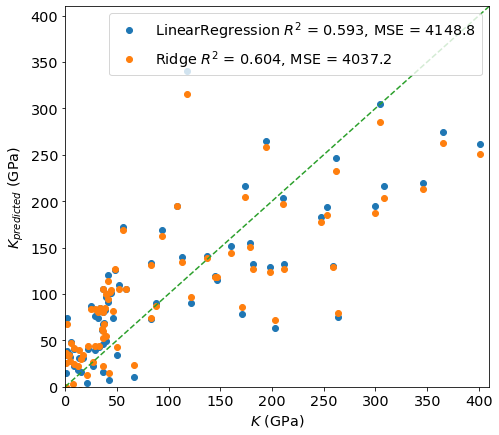

In [13]:
from sklearn.model_selection import cross_val_predict

reg1 = linear_model.LinearRegression()
yhat1 = cross_val_predict(reg1, z, y, cv=kfold)
r2_1 = r2_score(y, yhat1)
mae1 = mean_squared_error(y, yhat1)
label1 = "LinearRegression $R^2$ = %.3f, MSE = %.1f" % (r2_1, mae1)


reg2 = linear_model.Ridge(alpha=best_alpha, max_iter=10000)
yhat2 = cross_val_predict(reg2, z, y, cv=kfold)
r2_2 = r2_score(y, yhat2)
mae2 = mean_squared_error(y, yhat2)
label2 = "Ridge $R^2$ = %.3f, MSE = %.1f" % (r2_2, mae2)

f, ax = plt.subplots(figsize=(7.6, 7))
plt.plot(y, yhat1, 'o', label=label1)
plt.plot(y, yhat2, 'o', label=label2)
l = plt.ylabel("$K_{predicted}$ (GPa)")
l = plt.xlabel("$K$ (GPa)")
plt.legend()
plt.xlim([0, 410])
plt.ylim([0, 410])
plt.plot([0, 410], [0, 410], '--')

Text(0.5, 1.0, 'LASSO')

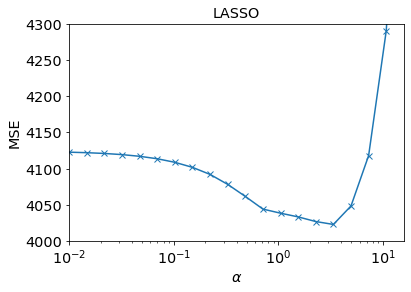

In [14]:
alphas = np.logspace(-2, 1.2, 20)
results = []
coeffs = []
for alpha in alphas:
    lasso = linear_model.Lasso(alpha=alpha, max_iter=1000000)
    lasso.fit(z, y)
    coeffs.append(lasso.coef_)
    lasso = linear_model.Lasso(alpha=alpha, max_iter=100000)
    scores = cross_validate(lasso, z, y, cv=kfold, scoring='neg_mean_squared_error')
    # print(scores)
    results.append((alpha, -np.mean(scores["test_score"])))

results = pd.DataFrame(results, columns=["alpha", "score"])
plt.plot(results["alpha"], results["score"], '-x')
plt.xscale('log')
plt.xlim([1e-2, 10**1.2])
plt.ylim([4000, 4300])
plt.xlabel(r'$\alpha$')
plt.ylabel('MSE')
plt.title('LASSO')

In [15]:
coeffdata = pd.DataFrame(coeffs, columns=features)
coeffdata["alpha"] = alphas
print(coeffdata)

           MP         BP         Z          X         r      alpha
0   42.746459  43.236646 -4.324512  29.979094  2.370134   0.010000
1   42.749970  43.212609 -4.292546  29.931785  2.313476   0.014737
2   42.755144  43.177184 -4.245438  29.862065  2.229977   0.021719
3   42.762769  43.124978 -4.176013  29.759316  2.106921   0.032008
4   42.774006  43.048039 -4.073698  29.607889  1.925569   0.047172
5   42.790567  42.934651 -3.922913  29.384727  1.658302   0.069519
6   42.818432  42.764279 -3.700389  29.055887  1.264872   0.102453
7   42.854284  42.518129 -3.372918  28.571218  0.684400   0.150990
8   42.913105  42.184696 -2.962608  27.982689  0.000000   0.222520
9   43.033481  41.870184 -2.785750  27.860556  0.000000   0.327936
10  43.209407  41.408132 -2.525332  27.680721 -0.000000   0.483293
11  43.468414  40.727447 -2.141584  27.415720 -0.000000   0.712249
12  43.853570  39.720890 -1.575512  27.024807 -0.000000   1.049670
13  44.401481  38.173414 -0.571451  26.152182 -0.403222   1.54